In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#importing all datasets

cities = ['amsterdam', 'athens', 'barcelona', 'berlin',
          'budapest', 'lisbon', 'london', 'paris',
          'rome', 'vienna']

days = ['weekdays', 'weekends']

all_airbnb_prices = pd.read_csv("/content/drive/MyDrive/Career/Data_Analyst/Projects/Personal/amsterdam_weekdays.csv",
                                index_col=[0])
all_airbnb_prices['city'] = 'Amsterdam'
all_airbnb_prices['weekday'] = True
count = all_airbnb_prices.shape[0]

i = 0
for city in cities:
  for day in days:
    if i == 0:
      i += 1
      continue
    import_string = "/content/drive/MyDrive/Career/Data_Analyst/Projects/Personal/{}_{}.csv".format(city, day)
    placeholder_df = pd.read_csv(import_string, index_col=[0])
    placeholder_df['city'] = city.capitalize()
    placeholder_df['weekday'] = True if day=="weekdays" else False
    count += placeholder_df.shape[0]
    all_airbnb_prices = pd.concat([all_airbnb_prices, placeholder_df], ignore_index=True)

all_airbnb_prices.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekday
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,True
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,True
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,True
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,True
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,True


We can get rid of the index columns, they do not provide any information about the AirBnBs.

In [4]:
# Drop redundant/not useful columns

all_airbnb_prices.drop(['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm'], axis=1, inplace=True)

# Change True/False columns to 0/1 columns

all_airbnb_prices[['room_shared', 'room_private',
                 'host_is_superhost', 'weekday']] = all_airbnb_prices[['room_shared',
                                                          'room_private', 'host_is_superhost',
                                                            'weekday']].astype(int)

all_airbnb_prices.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,weekday
0,194.033698,Private room,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772,Amsterdam,1
1,344.245776,Private room,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432,Amsterdam,1
2,264.101422,Private room,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103,Amsterdam,1
3,433.529398,Private room,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663,Amsterdam,1
4,485.552926,Private room,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508,Amsterdam,1


In [5]:
all_airbnb_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  int64  
 3   room_private                51707 non-null  int64  
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  int64  
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  lng                         517

In [6]:
# The below is to check if the room_type category is one-hot encoded by
# room_private and room_shared

expected_relationships = {
    "Private room": {"room_shared": False, "room_private": True},
    "Shared room": {"room_shared": True, "room_private": False},
    "Entire home/apt": {"room_shared": False, "room_private": False}
}

# Create a mask for each relationship
masks = [
    (all_airbnb_prices["room_type"] == room_type) &
    (all_airbnb_prices["room_shared"] == expected_values["room_shared"]) &
    (all_airbnb_prices["room_private"] == expected_values["room_private"])
    for room_type, expected_values in expected_relationships.items()
]

combined_mask = pd.concat(masks, axis=1).any(axis=1)

# Check for inconsistencies
inconsistent_rows = all_airbnb_prices[~combined_mask]

if not inconsistent_rows.empty:
    print("Column is NOT one-hot encoded")
    print(inconsistent_rows)
else:
    print("Column IS one-hot encoded")

Column IS one-hot encoded


Since the `room_type` column is one-hot encoded by the columns `room_shared` and `room_private`. Therefore, during EDA, the `room_type` column will be explored as a whole and not the `room_private` and `room_shared` columns. The `room_type` column will also be used during prediction using XGBoost, which can handle categorical variables

In [7]:
# Check if values for room_shared, room_private, host_is_superhost, multi, and biz categories are only binary

print("There are {} values in room_shared, room_private, host_is_superhost, multi, and biz categories"
      .format("only binary" if all_airbnb_prices[['room_shared', 'room_private',
                                                'host_is_superhost', 'multi', 'biz']]
              .isin([0, 1]).all().all() else "non-binary"))

# Check that every column other than lng and lat have non negative values

print("There are {}negative non-coordinate values".format("no " if
                                (all_airbnb_prices.drop(['lat', 'lng',
                                                       'room_type', 'city', 'weekday'], axis=1) >= 0).all().all() else ""))

There are only binary values in room_shared, room_private, host_is_superhost, multi, and biz categories
There are no negative non-coordinate values


There are no null values, no non-negative non-coordinate values, and the boolean columns have binary values. The data appears to be clean.

In [8]:
all_airbnb_prices.describe(include='all')

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,weekday
count,51707.000000,51707,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707,51707.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,London,NaN
freq,NaN,32648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9993,NaN
mean,279.879591,NaN,0.007078,0.361518,3.161661,0.255903,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,7.426068,45.671128,NaN,0.493163
std,327.948386,NaN,0.083835,0.480445,1.298545,0.436372,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,9.799725,5.249263,NaN,0.499958
min,34.779339,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,-9.226340,37.953000,NaN,0.000000
25%,148.752174,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,-0.072500,41.399510,NaN,0.000000
50%,211.343089,NaN,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,4.873000,47.506690,NaN,0.000000
75%,319.694287,NaN,0.000000,1.000000,4.000000,1.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,13.518825,51.471885,NaN,1.000000


In [9]:
all_listings = all_airbnb_prices.groupby('city').realSum.count().reset_index()
weekday_listings = all_airbnb_prices.groupby('city').weekday.sum().reset_index()
weekday_listing_counts = pd.merge(all_listings, weekday_listings)
weekday_listing_counts['all_listings'] = weekday_listing_counts['realSum']
weekday_listing_counts['weekdays'] = weekday_listing_counts['weekday']
weekday_listing_counts['weekends'] = weekday_listing_counts['realSum'] - weekday_listing_counts['weekdays']
weekday_listing_counts['weekday_perc'] = weekday_listing_counts.apply(lambda row:
                                                                round((row['weekdays'] / row['all_listings'] * 100), 1), axis=1)
weekday_listing_counts = weekday_listing_counts.sort_values('weekday_perc', ascending=False).reset_index()
weekday_listing_counts['weekday_perc'] = weekday_listing_counts.weekday_perc.apply(lambda x: str(x)+"%")
weekday_listing_counts.drop(['realSum', 'weekday', 'index'], axis=1, inplace=True)

all_weekdays = weekday_listing_counts['weekdays'].sum()
total_listings = weekday_listing_counts['all_listings'].sum()
total_perc = round(all_weekdays/total_listings * 100, 1)

print("Total Weekday Percentage: ", total_perc, "%")

weekday_listing_counts

Total Weekday Percentage:  49.3 %


,city,all_listings,weekdays,weekends,weekday_perc
0,Barcelona,2833,1555,1278,54.9%
1,Amsterdam,2080,1103,977,53.0%
2,Berlin,2484,1284,1200,51.7%
3,Budapest,4022,2074,1948,51.6%
4,Athens,5280,2653,2627,50.2%
5,Rome,9027,4492,4535,49.8%
6,Lisbon,5763,2857,2906,49.6%
7,Vienna,3537,1738,1799,49.1%
8,Paris,6688,3130,3558,46.8%
9,London,9993,4614,5379,46.2%


The number of weekday entries and weekend entries are approximately equal across all cities, so the dataset is fairly balanced.

In [10]:
weekday_weekend_airbnbs = all_airbnb_prices[all_airbnb_prices.duplicated(subset=["lat", "lng"], keep=False)]
weekday_weekend_airbnbs = weekday_weekend_airbnbs.sort_values("lat")
all_airbnb_prices['duplicated'] = all_airbnb_prices.duplicated(subset=["lat", "lng"], keep='last')

#Trnasforming with groupby
weekday_weekend_airbnbs['price_difference'] = (
  weekday_weekend_airbnbs.groupby(["lat", "lng"])['realSum'].transform(lambda x: x.max() - x.min())
)

different_priced_duplicates = weekday_weekend_airbnbs[weekday_weekend_airbnbs['price_difference'] > 0.1]

if len(different_priced_duplicates) > 0:
  print("Prices for weekday and weekend entries of the same AirBnB are NOT the same")
else:
  print("Prices for weekday and weekend entries of the same AirBnB ARE the same")

different_priced_duplicates = different_priced_duplicates.drop(columns='price_difference')

different_priced_duplicates.head(6)

Prices for weekday and weekend entries of the same AirBnB are NOT the same


,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,weekday
6614,87.877581,Entire home/apt,0,0,4.0,0,0,0,10.0,93.0,1,1.997930,0.454652,23.7391,37.95781,Athens,0
3721,92.798725,Entire home/apt,0,0,4.0,0,0,0,10.0,93.0,1,1.997904,0.454679,23.7391,37.95781,Athens,1
6741,85.768519,Entire home/apt,0,0,6.0,0,0,1,10.0,100.0,2,2.117541,0.230988,23.7260,37.95800,Athens,0
4701,92.798725,Entire home/apt,0,0,5.0,1,1,0,10.0,100.0,3,2.192079,0.405751,23.7240,37.95800,Athens,1
2382,81.081714,Entire home/apt,0,0,4.0,1,0,0,9.0,96.0,2,2.192081,0.405764,23.7240,37.95800,Athens,1
4340,104.281396,Entire home/apt,0,0,2.0,0,0,1,10.0,95.0,1,2.117541,0.230980,23.7260,37.95800,Athens,1


In [11]:
realSum_rank_df = different_priced_duplicates.groupby("city").realSum.mean()
realSum_rank = realSum_rank_df.sort_values().index

Text(0.5, 1.0, 'Bar Chart of AirBnB Prices for AirBnBs with Different Prices on Weekdays and Weekends')

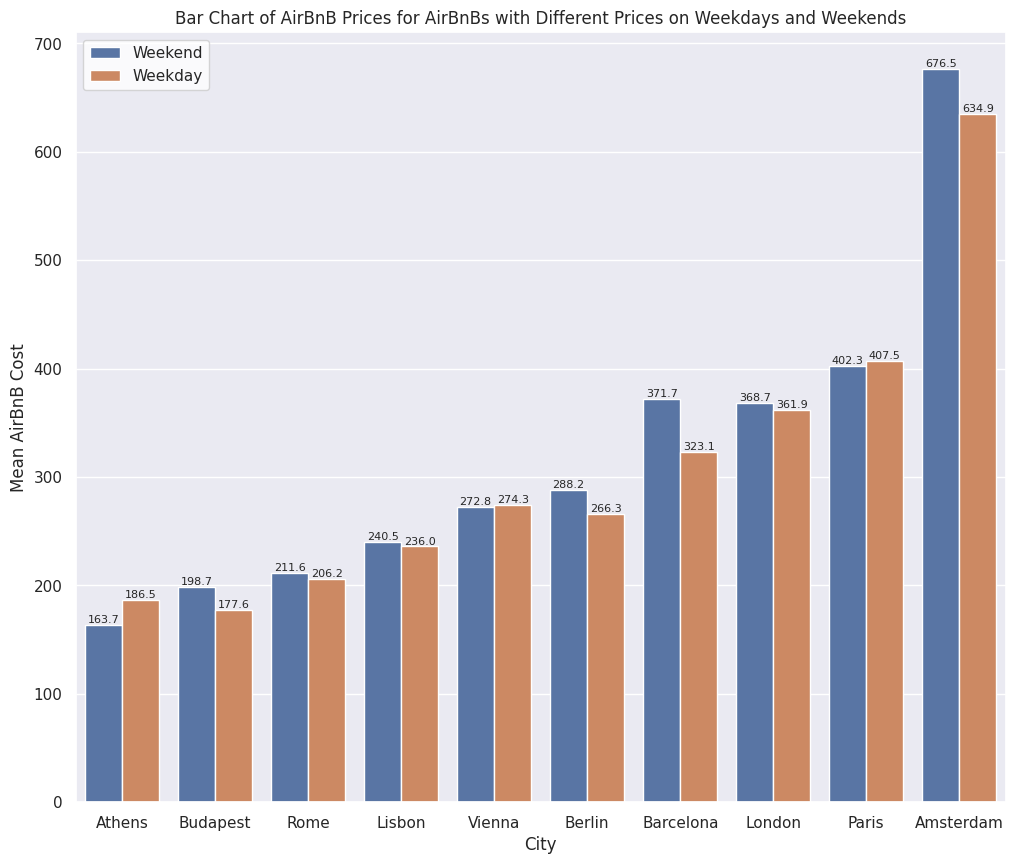

In [12]:
plt.figure(figsize=(12,10))
sns.set_theme()
bar_plot = sns.barplot(x = "city", y = "realSum", hue="weekday",
            data=different_priced_duplicates, estimator="mean", errorbar=None,
            order=realSum_rank)
plt.rcParams['font.size'] = 8
for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt='%.1f')
plt.legend(loc='upper left', labels=['Weekend', 'Weekday'], facecolor='white')
plt.ylabel('Mean AirBnB Cost')
plt.xlabel('City')
plt.title('Bar Chart of AirBnB Prices for AirBnBs with Different Prices on Weekdays and Weekends')

Text(0.5, 1.0, 'Bar Chart of Percentage Difference of AirBnB Prices from Weekends to Weekdays for AirBnBs with Different Prices on Weekdays and Weekends')

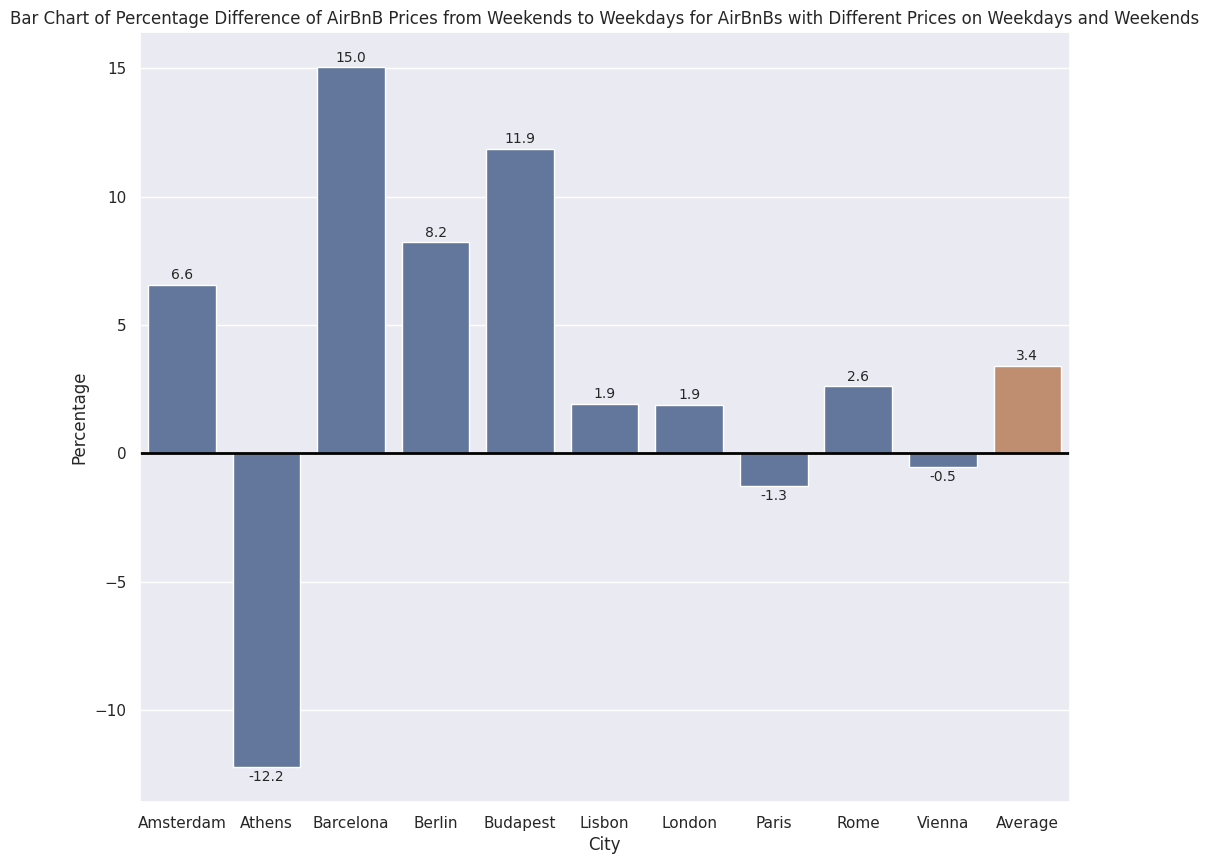

In [13]:
duplicate_means = different_priced_duplicates.groupby(["city", 'weekday']).realSum.mean().reset_index()
grouped_duplicates = duplicate_means.pivot(index="city", columns="weekday", values="realSum")
grouped_duplicates['percentage'] = (grouped_duplicates[0] - grouped_duplicates[1])/grouped_duplicates[1] * 100
cities = grouped_duplicates.index.tolist()
cities.append("Average")
percentages = grouped_duplicates.percentage.tolist()
percentages.append(np.mean(grouped_duplicates.percentage.tolist()))

plt.figure(figsize=(12,10))
color_palette = ["#5975A4"] * 11
color_palette[10] = '#CC8963'
bar_plot = sns.barplot(x = cities, y = percentages, palette = color_palette)
plt.rcParams['font.size'] = 10
bar_plot.bar_label(bar_plot.containers[0], fmt='%.1f', padding=2)
bar_plot.axhline(0, color='black', linewidth=2)
plt.xlabel('City')
plt.ylabel("Percentage")
plt.title('Bar Chart of Percentage Difference of AirBnB Prices from Weekends to Weekdays for AirBnBs with Different Prices on Weekdays and Weekends')

AirBnBs listed with different prices on weekdays and weekends are generally priced higher on the weekends. Averaged across all the cities, the increase in price is about 3.4% from weekdays to weekends for such AirBnBs. The difference is particularly pronounced in Barcelona, with a 15% increase from weekdays to weekends. Surprisingly weekend prices are 12.2% lower in Athens. This may be indicative of how Athens is treated as a travel destination: maybe the ratio of business to leisure travellers is higher in Athens as compared to the other locations. However, this cannot be derived simply from the above plot.

From the previous barchart it can be seen that Athens has the lowest average AirBnB price. This might suggest that Athens is not the most appealing holiday location and that the reduction of price in the weekends aims to entice more holiday-goers to come to Athens over the weekend.

Text(0.5, 1.0, 'Bar Chart of AirBnB Prices for all AirBnBs')

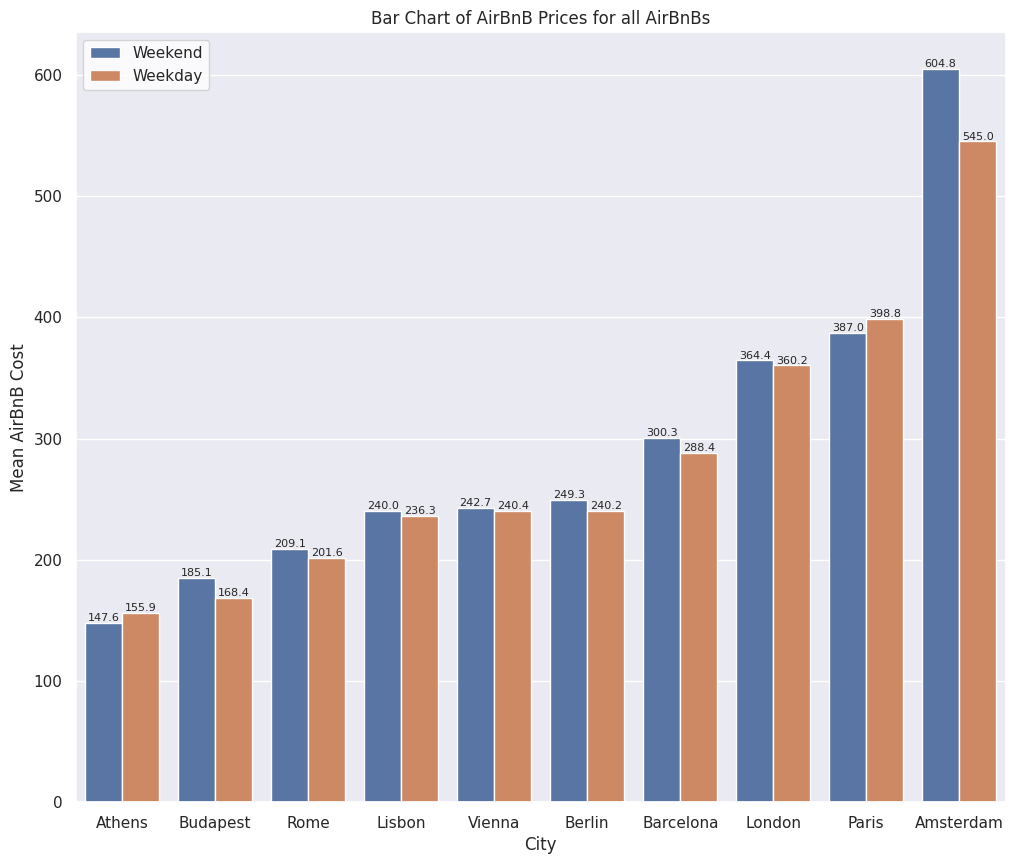

In [14]:
plt.figure(figsize=(12,10))
sns.set_theme()
bar_plot = sns.barplot(x = "city", y = "realSum", hue="weekday",
            data=all_airbnb_prices, estimator="mean", errorbar=None,
            order=realSum_rank)
plt.rcParams['font.size'] = 8
for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt='%.1f')
plt.legend(loc='upper left', labels=['Weekend', 'Weekday'], facecolor='white')
plt.ylabel('Mean AirBnB Cost')
plt.xlabel('City')
plt.title('Bar Chart of AirBnB Prices for all AirBnBs')

Athens has the lowest AirBnB prices, while Amsterdam has the highest AirBnB prices by far.

Text(0.5, 1.0, 'Bar Chart of Percentage Difference of AirBnB Prices from Weekends to Weekdays for all AirBnBs')

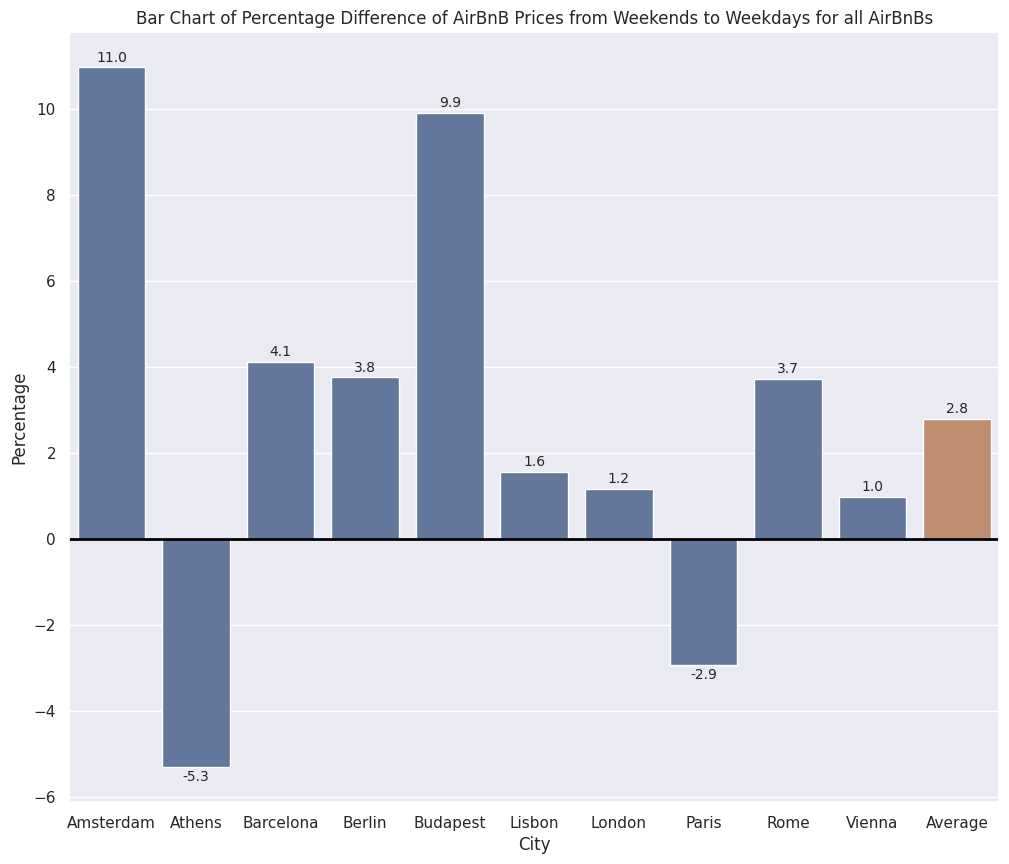

In [15]:
means = all_airbnb_prices.groupby(["city", 'weekday']).realSum.mean().reset_index()
grouped_means = means.pivot(index="city", columns="weekday", values="realSum")
grouped_means['percentage'] = (grouped_means[0] - grouped_means[1])/grouped_means[1] * 100
percentages_all = grouped_means.percentage.tolist()
percentages_all.append(np.mean(grouped_means.percentage.tolist()))

plt.figure(figsize=(12,10))
bar_plot = sns.barplot(x = cities, y = percentages_all, palette = color_palette)
plt.rcParams['font.size'] = 10
bar_plot.bar_label(bar_plot.containers[0], fmt='%.1f', padding=2)
bar_plot.axhline(0, color='black', linewidth=2)
plt.xlabel('City')
plt.ylabel("Percentage")
plt.title('Bar Chart of Percentage Difference of AirBnB Prices from Weekends to Weekdays for all AirBnBs')

All AirBnBs are generally priced higher on the weekends. Averaged across all the cities, the increase in price is about 2.8% from weekdays to weekends. The difference is particularly pronounced in Amsterdam, with a 11% increase from weekdays to weekends. Weekend prices are once again lower in Athens, this time by 5.3%. Surprisingly, Budapest has a 9.9% increase from weekdays to weekends, despite having the second lowest prices for AirBnBs across all the listed European cities. More information about the reason for travel to Budapest would be useful.

Text(0.5, 1.0, 'Histograms of AirBnB Prices')

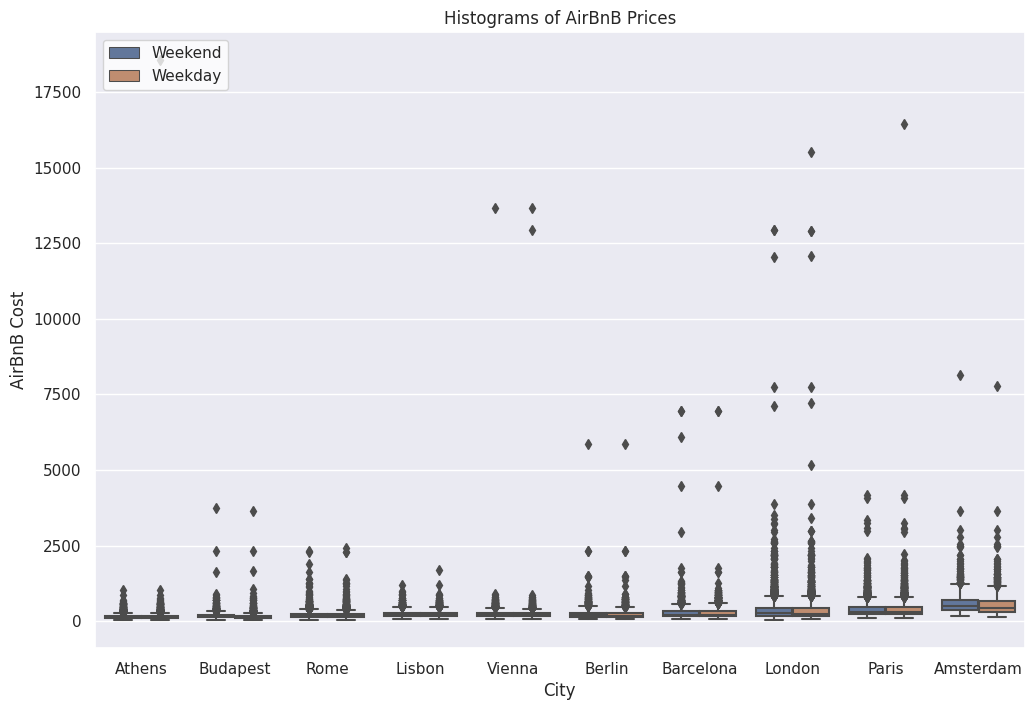

In [16]:
plt.figure(figsize=(12, 8))
sns.set_theme()
box_plot = sns.boxplot(x="city", y="realSum", hue="weekday",
            data=all_airbnb_prices, order=realSum_rank, palette = ["#5975A4", '#CC8963'],
            hue_order=[0, 1])
plt.legend(loc='upper left', facecolor='white')
plt.ylabel('AirBnB Cost')
plt.xlabel('City')
box_plot.legend_.set_title('')  # Remove default legend title
new_labels = ['Weekend', 'Weekday']  # Change the legend labels
for text, label in zip(box_plot.legend_.texts, new_labels):
    text.set_text(label)
plt.title('Histograms of AirBnB Prices')

The above histograms are to approximate the value from which the extreme outliers are apparent. This is mainly to prevent these outliers resulting in bias during prediction. We can observe that the most extreme outliers start at approximately **4000**.

Text(0.5, 1.0, 'Histograms of AirBnB Prices')

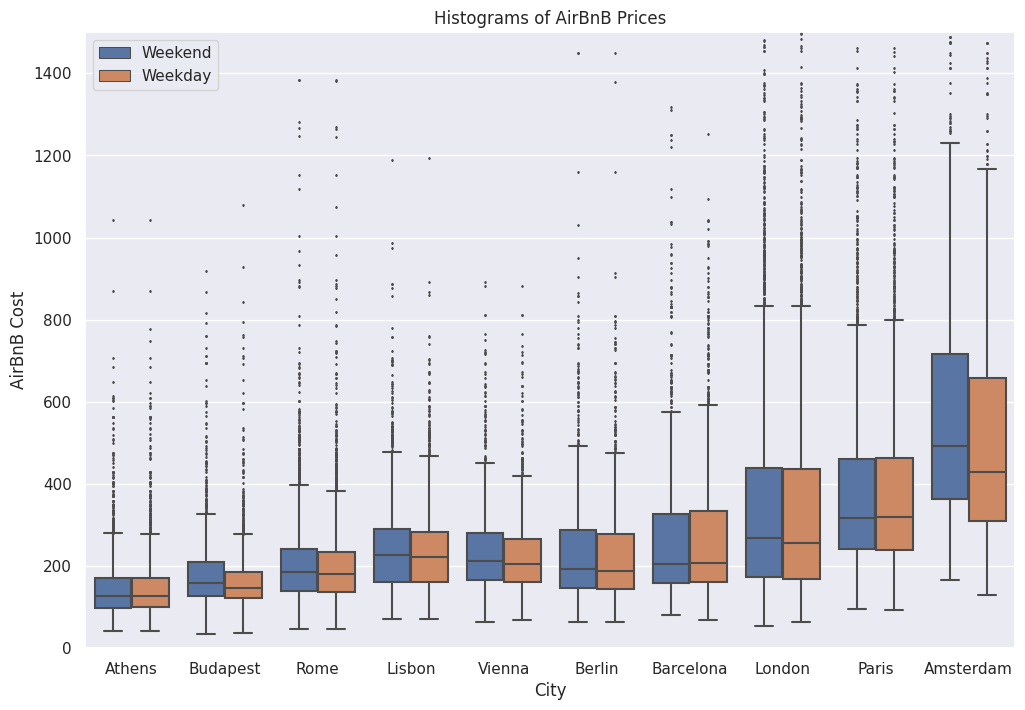

In [17]:
plt.figure(figsize=(12, 8))
sns.set_theme()
box_plot = sns.boxplot(x="city", y="realSum", hue="weekday",
            data=all_airbnb_prices, order=realSum_rank, fliersize=1)
plt.ylim(0, 1500)
plt.ylabel('AirBnB Cost')
plt.xlabel('City')
box_plot.legend_.set_title('')  # Remove default legend title
new_labels = ['Weekend', 'Weekday']  # Change the legend labels
for text, label in zip(box_plot.legend_.texts, new_labels):
    text.set_text(label)
plt.title('Histograms of AirBnB Prices')

From the histograms above it can be observed that London and Amsterdam have the widest range of AirBnB prices. Amsterdam in particular has the widest range of AirBnB prices. However, London has the most expensive AirBnBs, as can be observed by the much higher number of AirBnBs in London with prices above 2500 as compared to those from other cities.

In [18]:
room_type_count = all_airbnb_prices[all_airbnb_prices['duplicated'] == False]['room_type'].value_counts()

room_type_count

Entire home/apt    19411
Private room       10509
Shared room          205
Name: room_type, dtype: int64

In [19]:
bedrooms_count = all_airbnb_prices[all_airbnb_prices['duplicated'] == False]['bedrooms'].value_counts()

bedrooms_count.sort_index()

0      2607
1     20874
2      5648
3       924
4        57
5         6
6         1
8         1
9         6
10        1
Name: bedrooms, dtype: int64

In [20]:
person_capacity_count = all_airbnb_prices[all_airbnb_prices['duplicated'] == False]['person_capacity'].value_counts()

person_capacity_count.sort_index()

2.0    13874
3.0     3540
4.0     8332
5.0     1779
6.0     2600
Name: person_capacity, dtype: int64

In [21]:
cleanliness_rating_count = all_airbnb_prices[all_airbnb_prices['duplicated'] == False]['cleanliness_rating'].value_counts()

cleanliness_rating_count.sort_index(ascending=False)

10.0    17478
9.0      9063
8.0      2537
7.0       543
6.0       288
5.0        51
4.0        79
3.0         6
2.0        80
Name: cleanliness_rating, dtype: int64

In [22]:
guest_satisfaction_overall_count = all_airbnb_prices[all_airbnb_prices['duplicated'] == False]['guest_satisfaction_overall'].value_counts()

guest_satisfaction_overall_count.sort_index(ascending=False)

100.0    6167
99.0     1426
98.0     2321
97.0     2126
96.0     2083
95.0     1918
94.0     1535
93.0     1921
92.0     1161
91.0     1055
90.0     1508
89.0      773
88.0      806
87.0      734
86.0      443
85.0      440
84.0      389
83.0      341
82.0      197
81.0      125
80.0     1172
79.0       96
78.0       95
77.0       99
76.0       96
75.0      102
74.0       46
73.0      107
72.0       40
71.0       27
70.0      155
69.0       20
68.0       20
67.0       58
66.0        4
65.0       21
64.0        7
63.0       12
62.0        3
61.0        1
60.0      263
57.0        2
56.0        3
55.0        2
54.0        1
53.0        9
50.0       26
47.0        9
46.0        1
44.0        1
40.0       68
30.0        4
20.0       86
Name: guest_satisfaction_overall, dtype: int64

In [23]:
def classify_cleanliness(cleanliness):
  if cleanliness > 9:
    return '10'
  elif cleanliness > 8:
    return '9'
  elif cleanliness > 7:
    return '8'
  # elif cleanliness > 6:
  #   return '7'
  else:
    return '7≥'

def classify_satisfaction(satisfaction):
  if satisfaction > 94:
    return '95-100'
  elif satisfaction > 89:
    return '90-94'
  elif satisfaction > 79:
    return '80-89'
  elif satisfaction > 60:
    return '61-79'
  else:
    return '60≥'

def classify_bedrooms(bedrooms):
  if bedrooms > 2:
    return '3≤'
  elif bedrooms == 2:
    return '2'
  elif bedrooms == 1:
    return '1'
  else:
    return '0'

In [24]:
all_airbnb_prices['cleanliness_class'] = all_airbnb_prices['cleanliness_rating'].apply(classify_cleanliness)
all_airbnb_prices['bedroom_class'] = all_airbnb_prices['bedrooms'].apply(classify_bedrooms)
all_airbnb_prices['satisfaction_class'] = all_airbnb_prices['guest_satisfaction_overall'].apply(classify_satisfaction)
all_airbnb_prices['person_capacity_class'] = all_airbnb_prices['person_capacity'].astype('int')

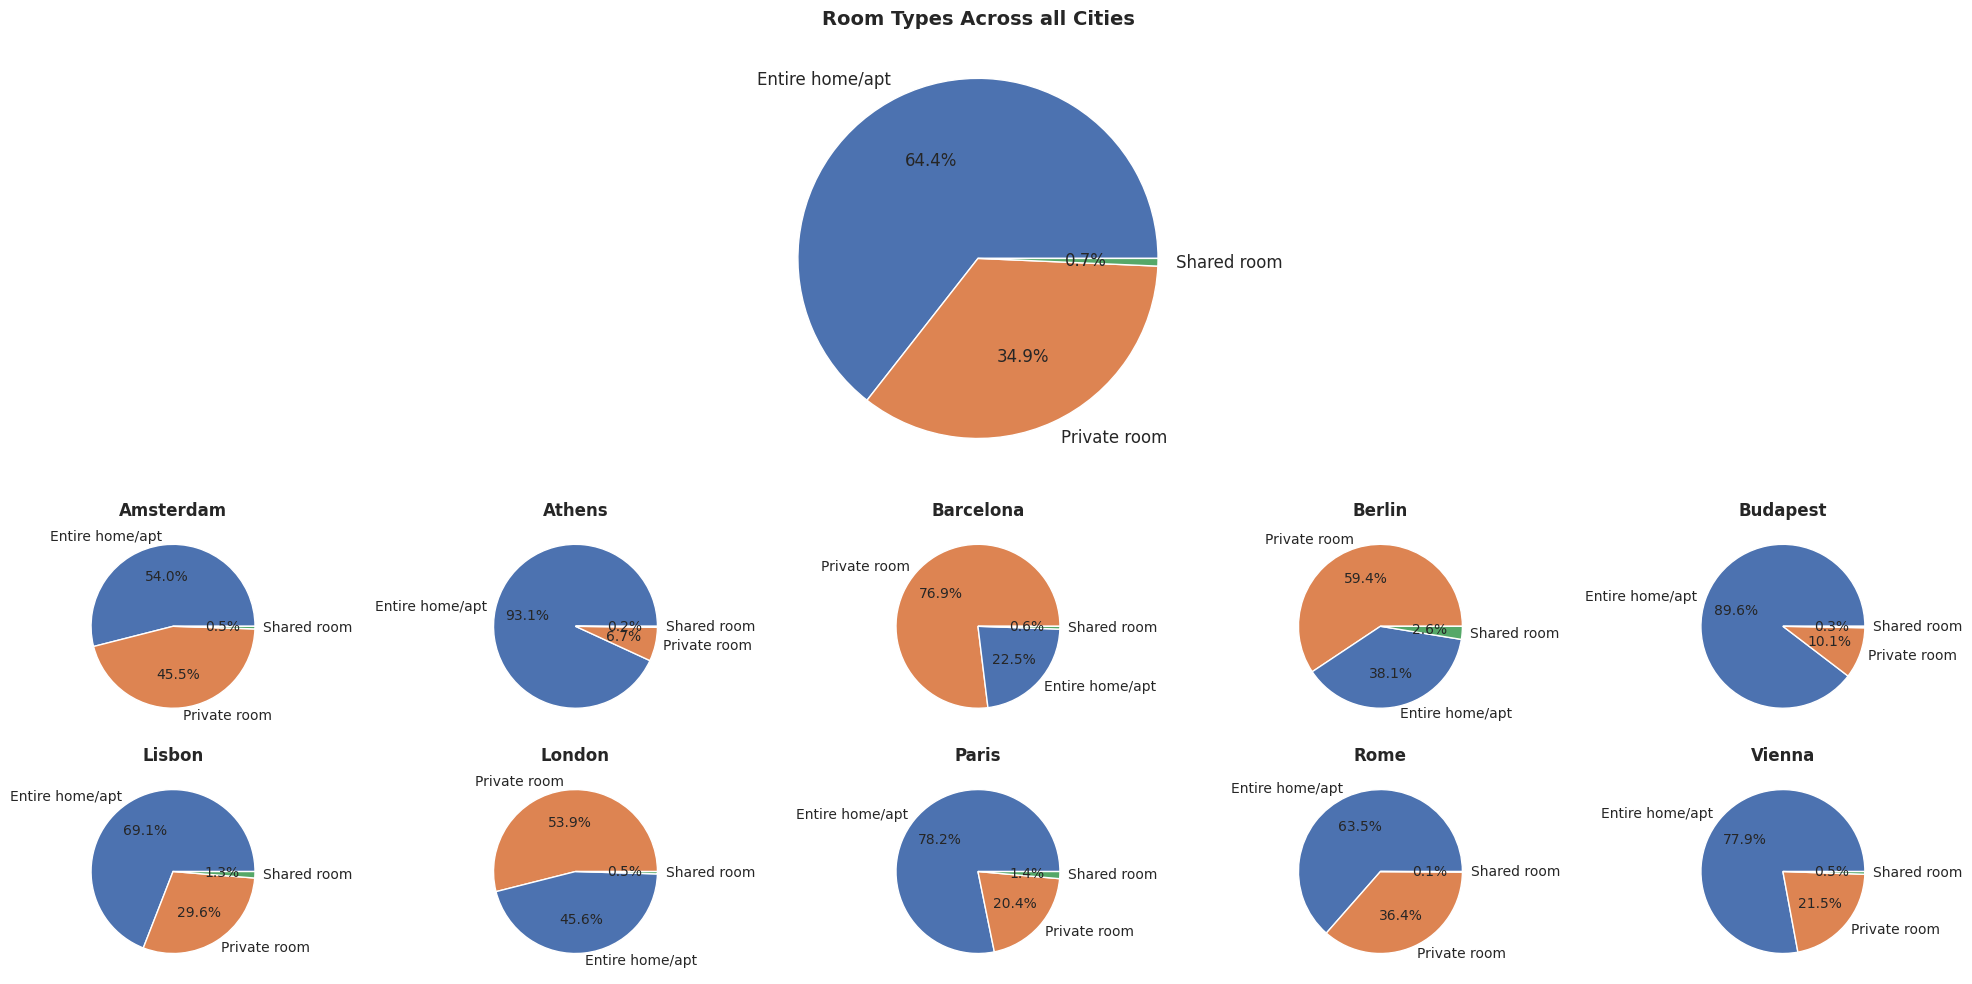

In [25]:
room_type_color_dict = {
    'Entire home/apt': '#4C72B0',
    'Private room': '#DD8452',
    'Shared room': '#55A868',
}

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(4, 5)

ax = fig.add_subplot(gs[0:2, 1:4])
room_type_counts = all_airbnb_prices.query("duplicated == False")['room_type'].value_counts()
room_type_values = room_type_counts.index.tolist()
room_type_freqs = room_type_counts.values.tolist()
ax.pie(room_type_freqs, labels=room_type_values, autopct='%2.1f%%', textprops={'size':12}, colors=[room_type_color_dict[room] for room in room_type_values])
plt.title("Room Types Across all Cities", fontsize=14, fontweight='bold')
plt.ylabel(None)

for i, city in enumerate(all_airbnb_prices['city'].unique().tolist()):
  ax = fig.add_subplot(gs[i//5 + 2, i%5])
  room_type_counts = all_airbnb_prices.query("duplicated == False and city == @city")['room_type'].value_counts()
  room_type_values = room_type_counts.index.tolist()
  room_type_freqs = room_type_counts.values.tolist()
  ax.pie(room_type_freqs, labels=room_type_values, autopct='%2.1f%%', textprops={'size':10}, colors=[room_type_color_dict[room] for room in room_type_values])
  plt.title(city, fontsize=12, fontweight='bold')
  plt.ylabel(None)

plt.tight_layout()


While this format is intuitive, it does end up makinng the charts difficult to read. It will probably be best to separate the total and city-by-city break downs of each statistic.

Text(0, 0.5, '')

<Figure size 500x500 with 0 Axes>

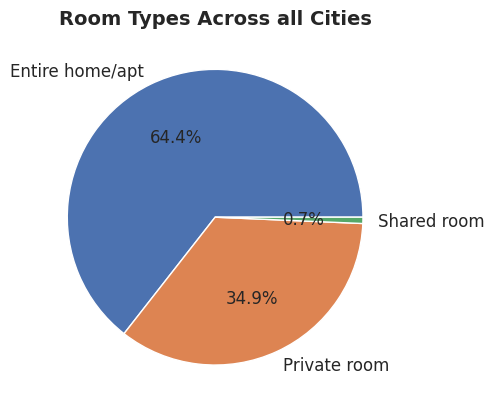

In [35]:
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots()
room_type_counts = all_airbnb_prices.query("duplicated == False")['room_type'].value_counts()
room_type_values = room_type_counts.index.tolist()
room_type_freqs = room_type_counts.values.tolist()
ax.pie(room_type_freqs, labels=room_type_values, autopct='%2.1f%%', textprops={'size':12}, colors=[room_type_color_dict[room] for room in room_type_values])
plt.title("Room Types Across all Cities", fontsize=14, fontweight='bold')
plt.ylabel(None)

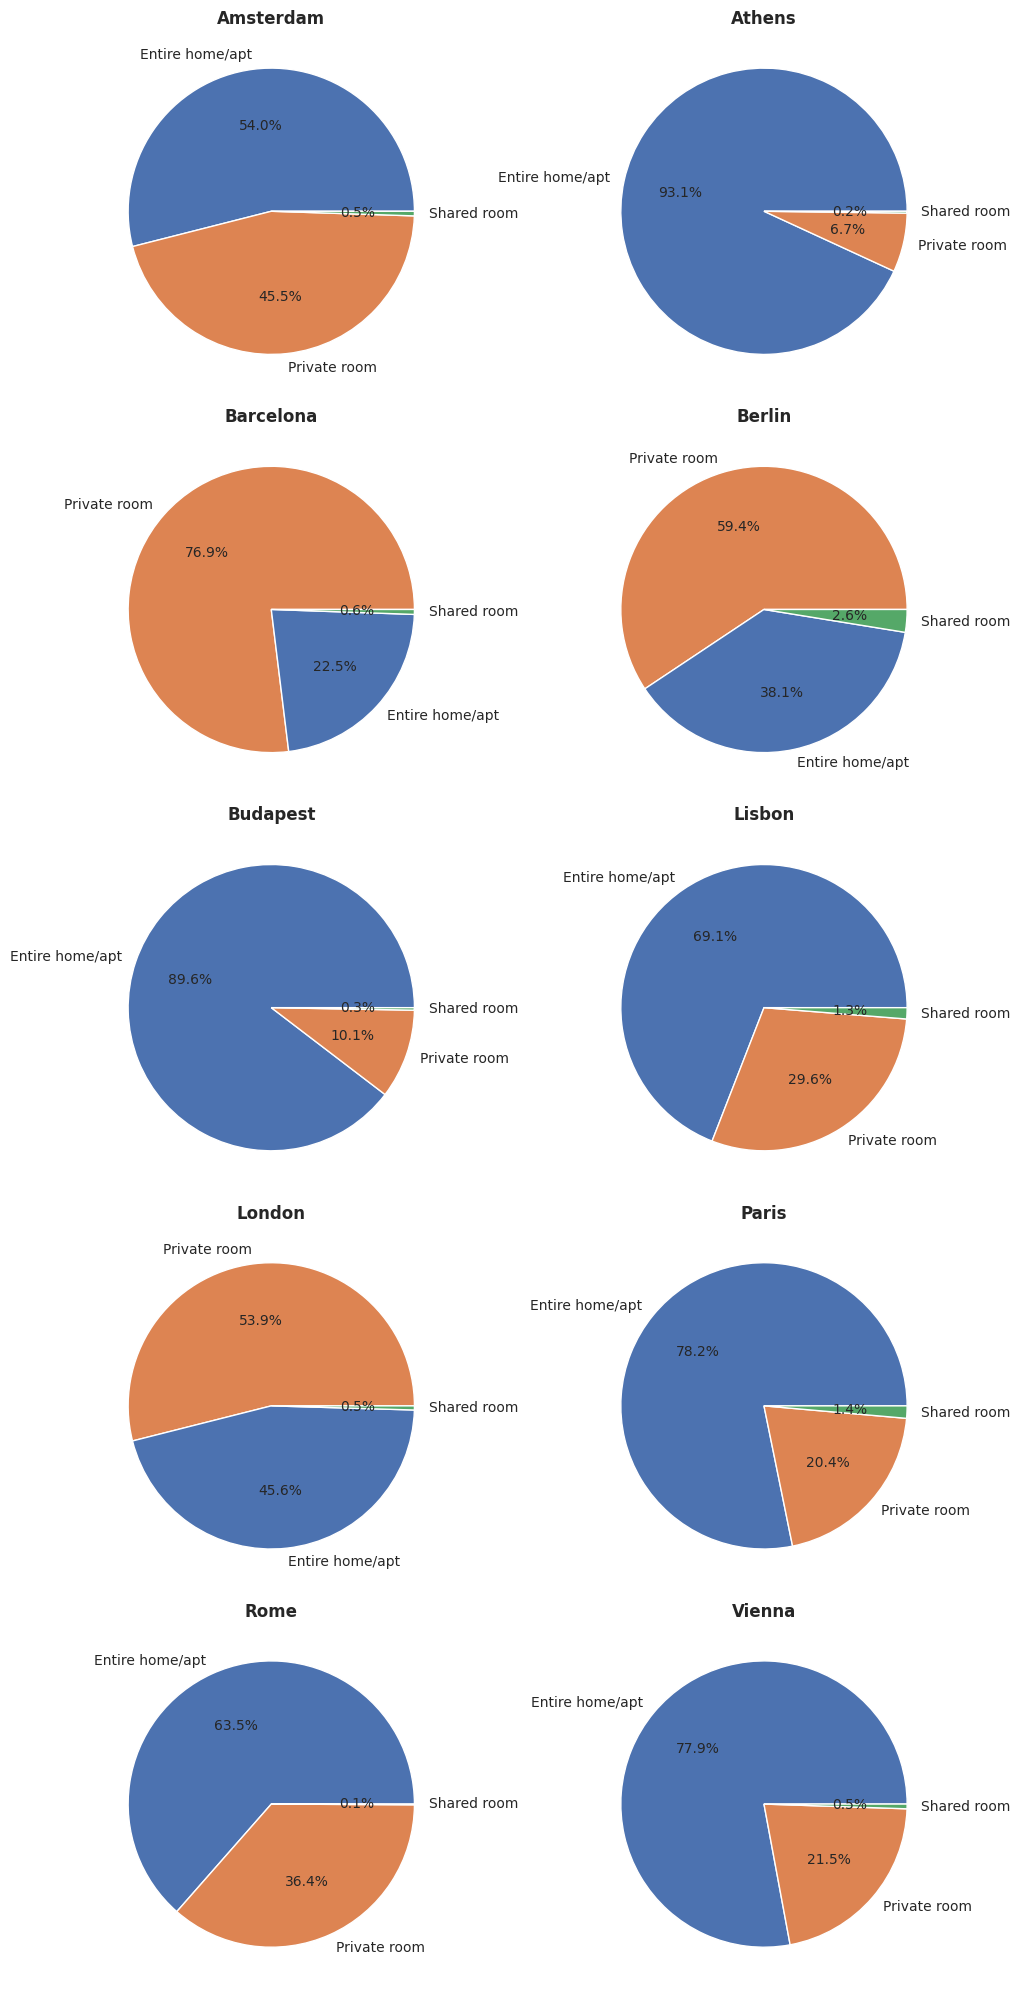

In [27]:
fig = plt.figure(figsize=(10, 40))

for i, city in enumerate(all_airbnb_prices['city'].unique().tolist()):
  ax = plt.subplot(10, 2, i+1)
  room_type_counts = all_airbnb_prices.query("duplicated == False and city == @city")['room_type'].value_counts()
  room_type_values = room_type_counts.index.tolist()
  room_type_freqs = room_type_counts.values.tolist()
  ax.pie(room_type_freqs, labels=room_type_values, autopct='%2.1f%%', textprops={'size':10}, colors=[room_type_color_dict[room] for room in room_type_values])
  plt.title(city, fontsize=12, fontweight='bold')
  plt.ylabel(None)

plt.tight_layout()

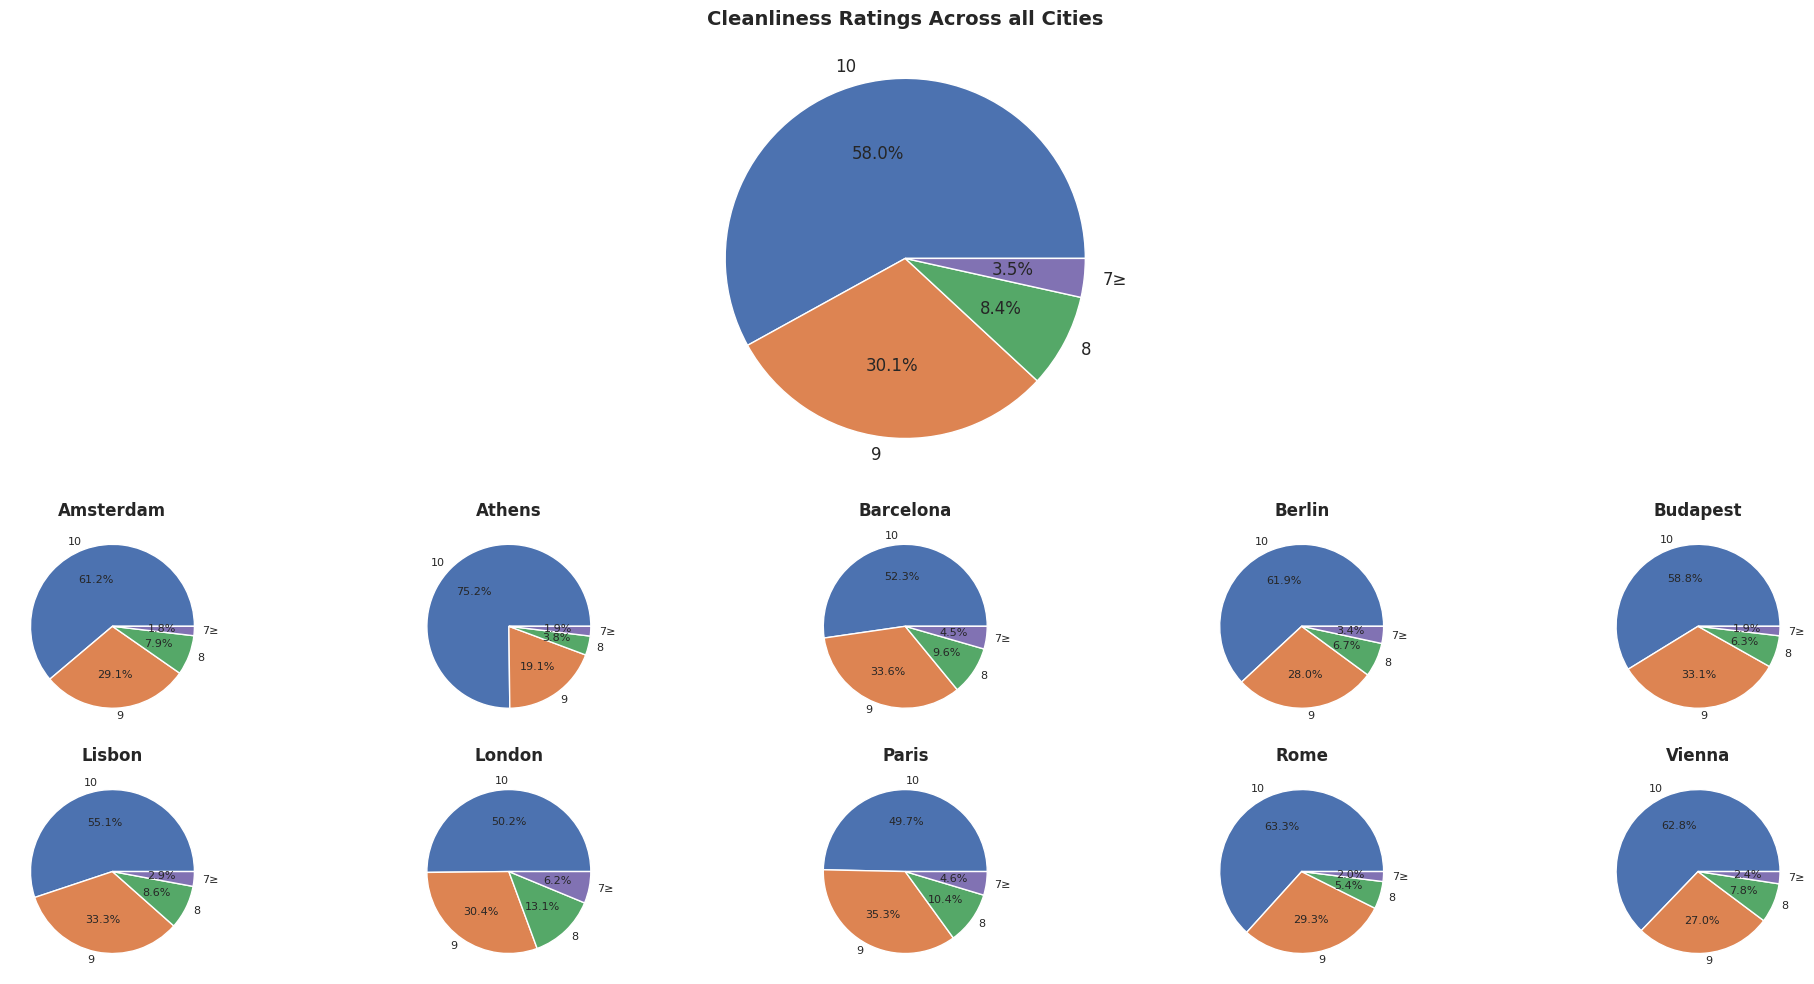

In [28]:
cleanliness_color_dict = {
    '10': '#4C72B0',
    '9': '#DD8452',
    '8': '#55A868',
    '7≥': '#8172B3',
    # '6≥': '#C44E52'
}

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(4, 5)

ax = fig.add_subplot(gs[0:2, 1:4])
cleanliness_counts = all_airbnb_prices.query("duplicated == False")['cleanliness_class'].value_counts()
cleanliness_values = cleanliness_counts.index.tolist()
cleanliness_freqs = cleanliness_counts.values.tolist()
ax.pie(cleanliness_freqs, labels=cleanliness_values, autopct='%2.1f%%', textprops={'size':12}, colors=[cleanliness_color_dict[rating] for rating in cleanliness_values])
plt.title("Cleanliness Ratings Across all Cities", fontsize=14, fontweight='bold')
plt.ylabel(None)

for i, city in enumerate(all_airbnb_prices['city'].unique().tolist()):
  ax = fig.add_subplot(gs[i//5 + 2, i%5])
  cleanliness_counts = all_airbnb_prices.query("duplicated == False and city == @city")['cleanliness_class'].value_counts()
  cleanliness_values = cleanliness_counts.index.tolist()
  cleanliness_freqs = cleanliness_counts.values.tolist()
  ax.pie(cleanliness_freqs, labels=cleanliness_values, autopct='%2.1f%%', textprops={'size':8}, colors=[cleanliness_color_dict[rating] for rating in cleanliness_values])
  plt.title(city, fontsize=12, fontweight='bold')
  plt.ylabel(None)

plt.tight_layout()

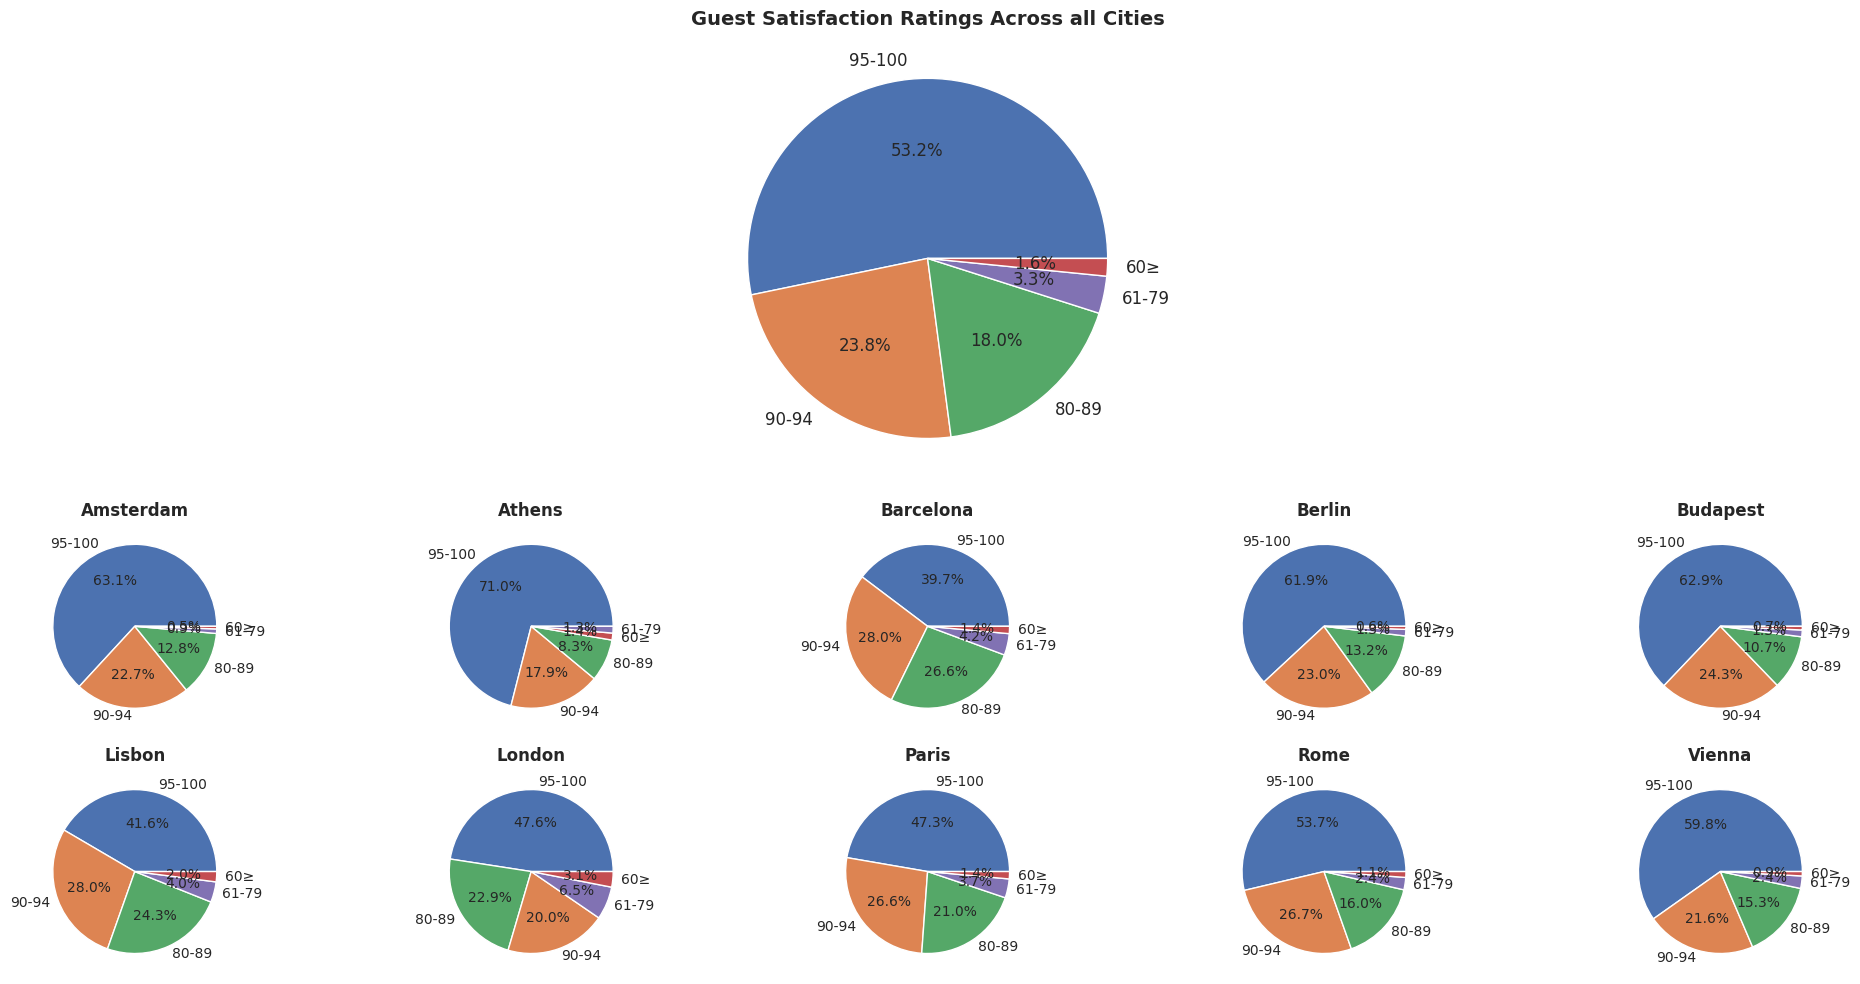

In [29]:
satisfaction_color_dict = {
    '95-100': '#4C72B0',
    '90-94': '#DD8452',
    '80-89': '#55A868',
    '61-79': '#8172B3',
    '60≥': '#C44E52'
}

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(4, 5)

ax = fig.add_subplot(gs[0:2, 1:4])
satisfaction_counts = all_airbnb_prices.query("duplicated == False")['satisfaction_class'].value_counts()
satisfaction_values = satisfaction_counts.index.tolist()
satisfaction_freqs = satisfaction_counts.values.tolist()
ax.pie(satisfaction_freqs, labels=satisfaction_values, autopct='%2.1f%%', textprops={'size':12}, colors=[satisfaction_color_dict[rating] for rating in satisfaction_values])
plt.title("Guest Satisfaction Ratings Across all Cities", fontsize=14, fontweight='bold')
plt.ylabel(None)

for i, city in enumerate(all_airbnb_prices['city'].unique().tolist()):
  ax = fig.add_subplot(gs[i//5 + 2, i%5])
  satisfaction_counts = all_airbnb_prices.query("duplicated == False and city == @city")['satisfaction_class'].value_counts()
  satisfaction_values = satisfaction_counts.index.tolist()
  satisfaction_freqs = satisfaction_counts.values.tolist()
  ax.pie(satisfaction_freqs, labels=satisfaction_values, autopct='%2.1f%%', textprops={'size':10}, colors=[satisfaction_color_dict[rating] for rating in satisfaction_values])
  plt.title(city, fontsize=12, fontweight='bold')
  plt.ylabel(None)

plt.tight_layout()

In [30]:
# Mark duplicates by creating a new column (mark weekdays as 1 if possible, if not either will do)
# Create piecharts with ranges for room_type, bedrooms, capacity, cleanliness_rating, guest_satisfaction_overall (use only non-dupes)
# piecharts should have a big piechart on top for all the cities collectively, followed by a breakdown of each city's pie chart
# Barchart of mean price with each category (include dupes)
# Multi, biz, host or superhost should have a horizontal bar plot with percentage solid bar (use only non-dupes)
# Barchart of mean price with each category (include dupes)


In [31]:
# Use latitude and longitude to find airbnbs with both weekday and weekend entries
# sparsity of each
# normalize distance from city centre (maybe distance from metro as well)
# split numerical stuff into ranges e.g. cleanliness rating and guest satisfaction
# use subplots to have more plots and make plots bigger
# Make one pie chart for everything and pie chart for each city (remove duplicate lat and lng, add a column saying which one are dupes)
# Room Type pie chart
# Person capacity pie chart
# Host is superhost, multi and biz percentage bar charts
# multi and biz comparison charts for weekdays and weekends (maybe just for biz)
# Cleanliness rating pie chart
# remove very high outliers from data pool when running predictions
# Normalize dist and metro_dist before doing a joint plot with them
# Use plotly to plot positions of airbnbs with price/dist/metro_dist maybe a composite of the above
# Potentially try to remove all outliers when running predictions
# Use linear regression and XgBoost and Neural Network for predicitions (try using GPU boosting)
# Use XgBoost importance and linear regression weights to determine most important features

# then the rest of the piecharts and barcharts
# Dual barchart of superhosts mean prices (Maybe do for all the other ranges as well)

In [32]:
# -london-weekends explanation: a rough, slightly disorganized attempt at
# predicting prices and presenting data only for london weekends
# the lack of data, particularly for london weekends probably hindered
# quality of prediction
# Data was augmented by scraping websites for the busiest tourist attractions
# and metro stations and calculating distances from the airbnbs to these points
# Matplotlib was used instead of plotly to plot geographical data, with the map
# image being obtained from OpenStreetMap.org
# link the notebook

In [33]:
# -full notebook explanation: a full notebook with explanations of everything
# from data cleaning to exploratory data analysis and prediction, as well as
# interpretations obtained from the prediction and analysis steps. Diagrams
# and analyses are presented with a logical flow meant for easy consumption
# of the data for subsequent use in the business side

In [34]:
# A markdown/latex/pdf summarising the findings of the notebook